In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas
import numpy as np

def get_roi_image(df, strip):
    
    row = df[df['strip'] == strip].iloc[0]
    
    image = cv2.imread(row['filename'])
    
    # # use the x and y coordinates to draw a rectangle around the ROI
    box_size = row['box_size'] * 2
    
    # Centroid of the ROI, originally the center of the box. Now it is
    x = int(row['x'] - box_size / 2)
    y = int(row['y'] - box_size / 2)
    
    
    slice_x1, slice_y1, slice_x2, slice_y2 = row['x1'], row['y1'], row['x2'], row['y2']

    # if any of the x, y, slice_x1, slice_y1, slice_x2, slice_y2 are negative, skip this row
    if x < 0 or y < 0 or slice_x1 < 0 or slice_y1 < 0 or slice_x2 < 0 or slice_y2 < 0:
        return None

    # crop the image to the ROI
    roi = image[y:y+box_size, x:x+box_size]

    # rotate the image by the rotation angle
    rotation_matrix = cv2.getRotationMatrix2D((box_size/2, box_size/2), row['rotation_angle'], 1)
    roi = cv2.warpAffine(roi, rotation_matrix, (box_size, box_size))

    # crop back to the original size
    roi = roi[int(box_size/4):int(box_size*3/4), int(box_size/4):int(box_size*3/4)]

    # draw the rectangle on the roi
    cv2.rectangle(roi, (slice_x1, slice_y1), (slice_x2, slice_y2), (0, 255, 0), 2)
    
    # draw a red dot at slice_x1, slice_y1
    cv2.circle(roi, (slice_x1, slice_y1), 5, (0, 0, 255), -1)
    
    # draw a blue dot at slice_x2, slice_y2
    cv2.circle(roi, (slice_x2, slice_y2), 5, (255, 0, 0), -1)

    # add the i and the label to the image
    cv2.putText(roi, f'{row["strip"]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # add the images to the roi list
    return roi


def shift_centroid(df, strip, dy, dx):
    df.loc[df['strip'] == strip, 'x'] += dx
    df.loc[df['strip'] == strip, 'y'] += dy

    return df

def shift_box(df, strip, dx, dy):
    df.loc[df['strip'] == strip, 'x1'] += dx
    df.loc[df['strip'] == strip, 'y1'] += dy
    df.loc[df['strip'] == strip, 'x2'] += dx
    df.loc[df['strip'] == strip, 'y2'] += dy

    return df

def adjust_box(df, strip, dx1, dy1, dx2, dy2):
    df.loc[df['strip'] == strip, 'x1'] += dx1
    df.loc[df['strip'] == strip, 'y1'] += dy1
    df.loc[df['strip'] == strip, 'x2'] += dx2
    df.loc[df['strip'] == strip, 'y2'] += dy2

    return df

In [5]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

def process_and_display_roi(file_path, mod_file_path, strip, centroid_adj, box_adj):
    """
    Process ROI adjustments and display the images.
    
    Parameters:
    - file_path (str): Path to the original CSV file.
    - mod_file_path (str): Path to the modified CSV file.
    - strip (int): The strip number to process.
    - centroid_adj (tuple): Adjustments for the centroid as (dx, dy).
    - box_adj (tuple): Adjustments for the bounding box as (dx1, dy1, dx2, dy2).
    """

    # Load the original dataframe
    df = pd.read_csv(file_path)
    
    # Load or create the modified dataframe
    try:
        df_mod = pd.read_csv(mod_file_path)
    except FileNotFoundError:
        print(f"Creating the {mod_file_path} file")
        df.to_csv(mod_file_path, index=False)
        df_mod = df.copy()

    # Make a copy to avoid modifying the original dataframe
    df2 = df.copy()

    # Adjust centroid and bounding box
    df2 = shift_centroid(df2, strip=strip, dx=centroid_adj[1], dy=centroid_adj[0])
    df2 = adjust_box(df2, strip=strip, dx1=box_adj[0], dy1=box_adj[1], dx2=box_adj[2], dy2=box_adj[3])

    # Display original and adjusted images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(get_roi_image(df, strip), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adjusted Image')
    image = get_roi_image(df2, strip)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Update the modified dataframe with the adjusted row
    row = df2[df2['strip'] == strip].iloc[0]
    df_mod[df_mod['strip'] == strip] = row

    # Save the modified dataframe
    df_mod.to_csv(mod_file_path, index=False)

    # Reload and verify changes
    df_mod = pd.read_csv(mod_file_path)
    mod_image = get_roi_image(df_mod, strip)

    # Plot the modified image
    plt.subplot(1, 3, 3)
    plt.title('Df_mod Image')
    plt.imshow(cv2.cvtColor(mod_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


```
fixed:
15: padding on the top is weird
2: box doesn't match grana

In progress:
107: box is catching lots of stroma
12: this image is just kind of bad
124: this one is rotated badly
132: this one has no box
136: this one doesn't line up right
150: box should be shifted left, to avoid blurry area
151: too much top stroma
156: image contrast is poor
158: image is shifted down
16: box is shifted down a touch
166: box doesn't fit grana, stroma is too high
167: box is shifted down
172: too much stroma showing on bottom
177: image is shifted down

199: box captures too much stroma on bottom
216: box too large, shows toomuch stroma on bottom
217: box out of grana space
230: box is shifted up
26: box shifted left, in blurry area
```

``` 
for nine selected:

todo:
101
106
134
135
161
176
187
229
232

fixed:



```

85 13 145 183
Width: 60
Height: 170


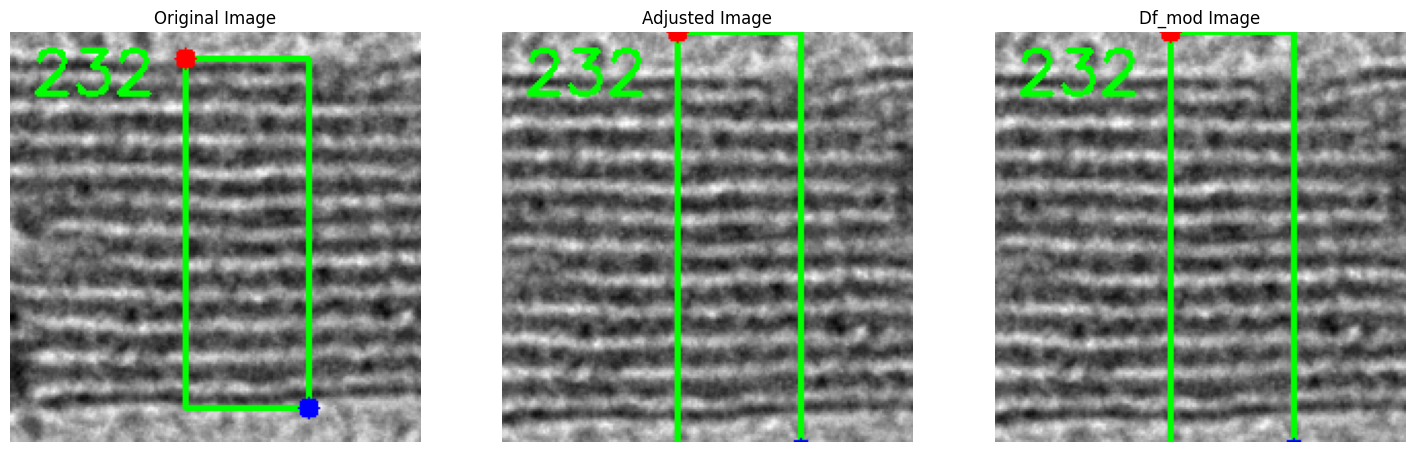

In [16]:

file_path='./metadata/rois_metadata_bignine_1.csv'
mod_file_path='./metadata/rois_metadata_bignine.csv'
strip = 232
centroid_adj = (-20, 0) # (dy, dx)
xy1_red = (0, -13) # (x1, y1)
xy2_blue = (0, 20) # (x2, y2)

metadata = pd.read_csv(file_path)
metadata = metadata[metadata['strip'] == strip].iloc[0]

# print the x1, y1, x2, y2 values from the metadata
print(metadata['x1'], metadata['y1'], metadata['x2'], metadata['y2'])

print(f"Width: {metadata['x2'] - metadata['x1']}")
print(f"Height: {metadata['y2'] - metadata['y1']}")

process_and_display_roi(
    file_path,
    mod_file_path,
    strip,
    centroid_adj,
    box_adj=(xy1_red[0], xy1_red[1], xy2_blue[0], xy2_blue[1])
)




In [4]:
# # strip number
# strip = 2
# centroid_adj = (-10, 25)
# box_adj = (10, 12, 0, -5)

# # load df
# df = pandas.read_csv('081624_roi_metadata.csv')

# # if 081624_roi_metadata_mod.csv doesn't exist, create it by saving the original df
# try:
#     df_mod = pandas.read_csv('081624_roi_metadata_mod.csv')
# except FileNotFoundError:
#     print("Creating the 081624_roi_metadata_mod.csv file")
#     df.to_csv('081624_roi_metadata_mod.csv', index=False)

# # make a copy to avoid modifying the original dataframe
# df2 = df.copy()

# df2 = shift_centroid(df2, strip=strip, dx=centroid_adj[0], dy=centroid_adj[1])

# # alter the df2 to adjust the x1, y1, x2, y2 values
# df2 = adjust_box(df2, strip=strip, dx1=box_adj[0], dy1=box_adj[1], dx2=box_adj[2], dy2=box_adj[3])

# # get the image for the strip
# image = get_roi_image(df2, strip)

# # show the image in a plot, with the unchanged image on the left and the changed image on the right
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 3, 1)
# # label the image with the strip number
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(get_roi_image(df, strip), cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title('Adjusted Image')
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# # find the row in the dataframe that corresponds to the strip
# row = df2[df2['strip'] == strip].iloc[0]

# # assign that to df_mod in the same way
# df_mod[df_mod['strip'] == strip] = row

# # save the modified dataframe to disk
# df_mod.to_csv('081624_roi_metadata_mod.csv', index=False)

# # now load it from disk to ensure we saved it correctly
# df_mod = pandas.read_csv('081624_roi_metadata_mod.csv')

# # load the mod_image from the df_mod dataframe
# mod_image = get_roi_image(df_mod, strip)

# # plot the image to ensure the changes were saved correctly
# plt.subplot(1, 3, 3)
# plt.title('Df_mod Image')
# plt.imshow(cv2.cvtColor(mod_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')